number of nodes of G0: 6394
number of nodes of G0: 5098
# of partitions for Louvain modularity = 457
The target protein YAP1802 belongs to community # 22
Position of YAP1802: [ 0.01348879 -0.11285223]
[('4932.YML001W', 523403381.55745345), ('4932.YKR001C', 476287258.3642932), ('4932.YAL030W', 470155370.3428139), ('4932.YGR167W', 419824280.96383613), ('4932.YJL154C', 413060129.4905788)]
[('4932.YML001W', 0.13350785340314136), ('4932.YAL030W', 0.13089005235602094), ('4932.YJL154C', 0.12303664921465969), ('4932.YOR089C', 0.12041884816753927), ('4932.YLR262C', 0.11518324607329844)]
Subgraph centrality rank: 14
Degree centrality rank: 29
YAP1802 degree: 27
Max degree: [('4932.YML001W', 51)]
[3, 6, 5, 6, 5, 6, 5, 5, 5, 5, 5, 5, 4, 12, 4, 5, 9, 11, 11, 11, 11, 12, 12, 9, 10, 9, 7, 9, 8, 7, 7, 10, 11, 11, 9, 8, 9, 7, 7, 11, 10, 9, 10, 9, 11, 11, 11, 11, 12, 12, 9, 10, 9, 7, 9, 8, 7, 7, 10, 11, 11, 9, 9, 9, 10, 9, 9, 9, 10, 9, 9, 9, 6, 4, 6, 6, 6, 6, 6, 9, 9, 9, 9, 10, 10, 9, 9, 9, 9, 10, 10, 4

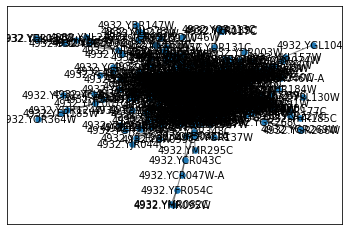

In [4]:
import networkx as nx
import community as community_louvain
import matplotlib.cm as cm
import numpy as np
import scipy as sp
from string import ascii_lowercase 

import csv
import matplotlib.pyplot as plt
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 32}

plt.rc('font', **font)
G0 = nx.read_weighted_edgelist("4932.protein.links.v11.5.txt",comments="#",nodetype=str) #Delete the header first or this might not work!

print('number of nodes of G0:',G0.number_of_nodes())
#Remove the essential proteins from G0
with open("essential_yeast.csv") as f:
    essential = csv.reader(f)
    for row in essential:
        if "4932."+row[1] in G0.nodes:
            G0.remove_node("4932."+row[1])
print('number of nodes of G0:',G0.number_of_nodes())

# delete those edges with a combined score of <= threshold_score (small confidence)
threshold_score = 700
for edge in G0.edges: 
    weight = list(G0.get_edge_data(edge[0],edge[1]).values())
    if(weight[0] <= threshold_score):
        G0.remove_edge(edge[0],edge[1])

partition = community_louvain.best_partition(G0)
number_of_communities = max(list(partition.values()))+1
print('# of partitions for Louvain modularity =',number_of_communities)
node_target = "4932.YGR241C"
print('The target protein YAP1802 belongs to community #',partition[node_target])
target_partition = []
for node in partition:
    if partition[node] == partition[node_target]:
        target_partition.append(node)
H = G0.subgraph(target_partition)
labels = {n:n for n in H}
pos = nx.spring_layout(H)
print("Position of YAP1802:", pos["4932.YGR241C"])
#Compute subgraph centrality of the community of YAP1802
H_SC = nx.subgraph_centrality(H)
#Sort the nodes in the community by subgraph centrality
H_SC = dict(sorted(H_SC.items(), key = lambda item: item[1], reverse = True))
H_SC_ls = []
for item in H_SC:
    H_SC_ls.append((item, H_SC[item]))
print(H_SC_ls[:5])
#Compute degree centrality of the community of YAP1802
H_DC = nx.degree_centrality(H)
#Sort the nodes in the community by degree centrality
H_DC = dict(sorted(H_DC.items(), key = lambda item: item[1], reverse = True))
H_DC_ls = []
for item in H_DC:
    H_DC_ls.append((item, H_DC[item]))
print(H_DC_ls[:5])
for i in range(0, len(H_SC_ls)):
    if H_SC_ls[i][0] == "4932.YGR241C":
        print("Subgraph centrality rank:", i)
    if H_DC_ls[i][0] == "4932.YGR241C":
        print("Degree centrality rank:", i)
#Find all cliques that YAP1802 is in
yap_cliques = []
yap_degree = H.degree("4932.YGR241C")
print("YAP1802 degree:", yap_degree)
print("Max degree:",H.degree(H_DC_ls[0]))
for clique in nx.find_cliques(H):
    if "4932.YGR241C" in clique:
        yap_cliques.append(clique)
        #print(clique)
#Length of cliques
clique_lengths = []
for clique in nx.find_cliques(H):
    clique_lengths.append(len(clique))
print(clique_lengths)
target_two = "4932.YLL001W"
nx.draw_networkx_nodes(H, pos, node_size = 30)
nx.draw_networkx_edges(H, pos, alpha=0.5)
nx.draw_networkx_labels(H,pos,labels,font_size=10)
plt.show()

alpha = 0.05
original: nodes = 1000, edges = 4975
backbone: nodes = 383, edges = 2241


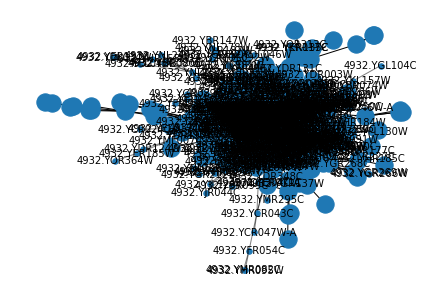

In [18]:
'''
This module implements the disparity filter to compute a significance score of edge weights in networks
'''

import networkx as nx
import numpy as np
from scipy import integrate
from backbone_network import get_graph_backbone


def disparity_filter(H, weight='weight'):
    ''' Compute significance scores (alpha) for weighted edges in G as defined in Serrano et al. 2009
        Args
            G: Weighted NetworkX graph
        Returns
            Weighted graph with a significance score (alpha) assigned to each edge
        References
            M. A. Serrano et al. (2009) Extracting the Multiscale backbone of complex weighted networks. PNAS, 106:16, pp. 6483-6488.
    '''
    
    if nx.is_directed(H): #directed case    
        N = nx.DiGraph()
        for u in G:
            
            k_out = H.out_degree(u)
            k_in = H.in_degree(u)
            
            if k_out > 1:
                sum_w_out = sum(np.absolute(H[u][v][weight]) for v in H.successors(u))
                for v in H.successors(u):
                    w = H[u][v][weight]
                    p_ij_out = float(np.absolute(w))/sum_w_out
                    alpha_ij_out = 1 - (k_out-1) * integrate.quad(lambda x: (1-x)**(k_out-2), 0, p_ij_out)[0]
                    N.add_edge(u, v, weight = w, alpha_out=float('%.4f' % alpha_ij_out))
                    
            elif k_out == 1 and G.in_degree(G.successors(u)[0]) == 1:
                #we need to keep the connection as it is the only way to maintain the connectivity of the network
                v = H.successors(u)[0]
                w = H[u][v][weight]
                N.add_edge(u, v, weight = w, alpha_out=0., alpha_in=0.)
                #there is no need to do the same for the k_in, since the link is built already from the tail
            
            if k_in > 1:
                sum_w_in = sum(np.absolute(H[v][u][weight]) for v in H.predecessors(u))
                for v in H.predecessors(u):
                    w = H[v][u][weight]
                    p_ij_in = float(np.absolute(w))/sum_w_in
                    alpha_ij_in = 1 - (k_in-1) * integrate.quad(lambda x: (1-x)**(k_in-2), 0, p_ij_in)[0]
                    N.add_edge(v, u, weight = w, alpha_in=float('%.4f' % alpha_ij_in))
        return N
    
    else: #undirected case
        B = nx.Graph()
        for u in G:
            k = len(G[u])
            if k > 1:
                sum_w = sum(np.absolute(G[u][v][weight]) for v in G[u])
                for v in G[u]:
                    w = G[u][v][weight]
                    p_ij = float(np.absolute(w))/sum_w
                    alpha_ij = 1 - (k-1) * integrate.quad(lambda x: (1-x)**(k-2), 0, p_ij)[0]
                    B.add_edge(u, v, weight = w, alpha=float('%.4f' % alpha_ij))
        return B

def disparity_filter_alpha_cut(G,weight='weight',alpha_t=0.4, cut_mode='or'):
    ''' Performs a cut of the graph previously filtered through the disparity_filter function.
        
        Args
        ----
        G: Weighted NetworkX graph
        
        weight: string (default='weight')
            Key for edge data used as the edge weight w_ij.
            
        alpha_t: double (default='0.4')
            The threshold for the alpha parameter that is used to select the surviving edges.
            It has to be a number between 0 and 1.
            
        cut_mode: string (default='or')
            Possible strings: 'or', 'and'.
            It works only for directed graphs. It represents the logic operation to filter out edges
            that do not pass the threshold value, combining the alpha_in and alpha_out attributes
            resulting from the disparity_filter function.
            
            
        Returns
        -------
        B: Weighted NetworkX graph
            The resulting graph contains only edges that survived from the filtering with the alpha_t threshold
    
        References
        ---------
        .. M. A. Serrano et al. (2009) Extracting the Multiscale backbone of complex weighted networks. PNAS, 106:16, pp. 6483-6488.
    '''    
    
    
    if nx.is_directed(G):#Directed case:   
        B = nx.DiGraph()
        for u, v, w in G.edges(data=True):
            try:
                alpha_in =  w['alpha_in']
            except KeyError: #there is no alpha_in, so we assign 1. It will never pass the cut
                alpha_in = 1
            try:
                alpha_out =  w['alpha_out']
            except KeyError: #there is no alpha_out, so we assign 1. It will never pass the cut
                alpha_out = 1  
            
            if cut_mode == 'or':
                if alpha_in<alpha_t or alpha_out<alpha_t:
                    B.add_edge(u,v, weight=w[weight])
            elif cut_mode == 'and':
                if alpha_in<alpha_t and alpha_out<alpha_t:
                    B.add_edge(u,v, weight=w[weight])
        return B

    else:
        B = nx.Graph()#Undirected case:   
        for u, v, w in G.edges(data=True):
            
            try:
                alpha = w['alpha']
            except KeyError: #there is no alpha, so we assign 1. It will never pass the cut
                alpha = 1
                
            if alpha<alpha_t:
                B.add_edge(u,v, weight=w[weight])
        return B                
            
if __name__ == '__main__':
    G = nx.barabasi_albert_graph(1000, 5)
    for u, v in G.edges():
        G[u][v]['weight'] = np.random.randint(1,100)
    alpha = 0.05
    G = disparity_filter(G)
    G2 = nx.Graph([(u, v, d) for u, v, d in G.edges(data=True) if d['alpha'] < alpha])
    print ('alpha = %s' % alpha)
    print ('original: nodes = %s, edges = %s' % (G.number_of_nodes(), G.number_of_edges()))
    print ('backbone: nodes = %s, edges = %s' % (H.number_of_nodes(), H.number_of_edges()))

target = "4932.YGR241"
graph_backbone = get_graph_backbone(H)
nx.draw(graph_backbone)
nx.draw_networkx_nodes(H, pos, node_size = 30)
nx.draw_networkx_edges(H, pos, alpha=0.5)
nx.draw_networkx_labels(H,pos,labels,font_size=10)
plt.show()